# Problem set 7: Solving the consumer problem with income risk

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Tasks

In [2]:
sm.init_printing(use_unicode=True)

## Optimization problem I

Consider the function

$$ 
f(\boldsymbol{x}) = f(x_1,x_2) = (x_1^2 - x_1x_2 + x_2^2)^2
$$

Define it in **sympy** by:

In [3]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (x1**2 - x1*x2 + x2**2)**2
f

The **Jacobian** is

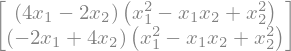

In [4]:
f1 = sm.diff(f,x1)
f2 = sm.diff(f,x2)
sm.Matrix([f1,f2])

The **Hessian**  is

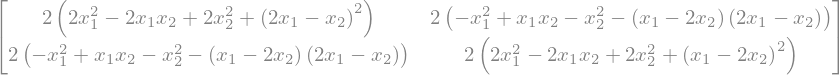

In [5]:
f11 = sm.diff(f,x1,x1)
f12 = sm.diff(f,x1,x2)
f21 = sm.diff(f,x2,x1)
f22 = sm.diff(f,x2,x2)
sm.Matrix([[f11,f12],[f21,f22]])

**Question A:** Create a 3D plot and a contour plot of $f(x_1,x_2)$ such as those in the answer below.

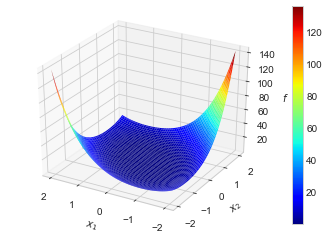

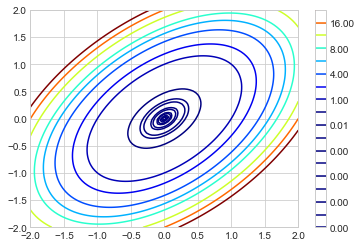

In [6]:
_f = sm.lambdify((x1,x2),f)

x_vec = np.linspace(-2,2,100)

# a. grids

x1_grid,x2_grid = np.meshgrid(x_vec,x_vec,indexing='ij')

f_grid = _f(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# e. add colorbar
fig.colorbar(cs);



#Contour plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
cs = ax.contour(x1_grid,x2_grid,f_grid,levels=levels,cmap=cm.jet)
fig.colorbar(cs);

**Answer:**

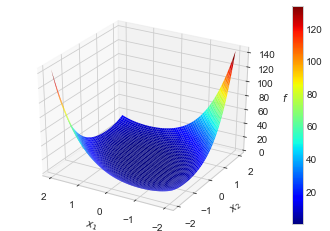

In [7]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-2,2,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
f_grid = _f(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# e. add colorbar
fig.colorbar(cs);

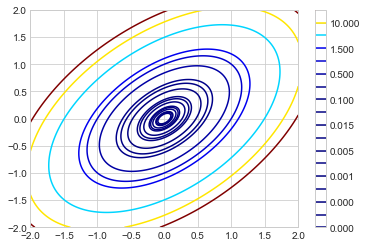

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
cs = ax.contour(x1_grid,x2_grid,f_grid,levels=levels,cmap=cm.jet)
fig.colorbar(cs);

**Question B:** Construct python functions for the jacobian and the hessian.

In [9]:
f_python = lambda x: _f(x[0],x[1])

# Store sympys in lists: 
xs = [x1,x2]
jacs = [f1,f2]
hessians = [f11,f12,f21,f22]

# generate python versions:
_jacs = [sm.lambdify(xs,jac) for jac in jacs]
_hessians = [sm.lambdify(xs,hess) for hess in hessians]

def f_jac(x):
    return np.array([jac(*x) for jac in _jacs])

def f_hess(x):
    answer = [hess(*x) for hess in _hessians]
    return np.array([answer[:2],answer[2:]])

**Answer:**

In [10]:
_f1 = sm.lambdify((x1,x2),f1)
_f2 = sm.lambdify((x1,x2),f2)
_f11 = sm.lambdify((x1,x2),f11)
_f12 = sm.lambdify((x1,x2),f12)
_f21 = sm.lambdify((x1,x2),f21)
_f22 = sm.lambdify((x1,x2),f22)

def f_jac(x):
    return np.array([_f1(x[0],x[1]),_f2(x[0],x[1])])

def f_hess(x):
    row1 = [_f11(x[0],x[1]),_f12(x[0],x[1])]
    row2 = [_f21(x[0],x[1]),_f22(x[0],x[1])]
    return np.array([row1,row2])


**Question C:** Minimize $f(x_1,x_2)$ using respectively

1. Nelder-Mead,
* BFGS without analytical jacobian,
* BFGS with analytical jacobian, and
* Newton-CG with analytical jacobian and hessian

Compare the results and discuss which optimizer you prefer.

**Optional:** If you wish, you can use the functions defined in the hidden cells below to also track how the optimizers converges to the solution.

In [11]:
def collect(x):
    
    # globals used to keep track across iterations
    global evals # set evals = 0 before calling optimizer
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialize list
    if evals == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [f_python(x0)]
        
    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(f_python(x))
    
    # c. increment number of evaluations
    evals += 1

In [12]:
def contour():
    
    global evals
    global x1s
    global x2s
    global fs
    
    # a. contour plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = np.sort([j*10**(-i) for i in [-1,0,1,2,3,4] for j in [0.5,1,1.5]])
    cs = ax.contour(x1_grid,x2_grid,f_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. function value
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 83


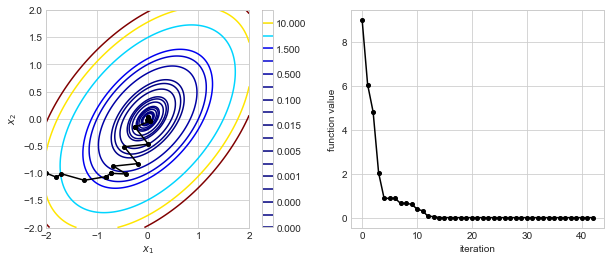

In [13]:
# Nelder-mead
x0 = [-2,-1] # suggested initial guess
evals = 0

result = optimize.minimize(f_python,x0,
                           method='Nelder-Mead',
                           callback=collect, # call the collect() before each iteration
                           options={'disp':True}) # display the results
contour()
info ={}
info['Nelder-Mead'] = [result.nit,result.nfev]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 112
         Gradient evaluations: 28


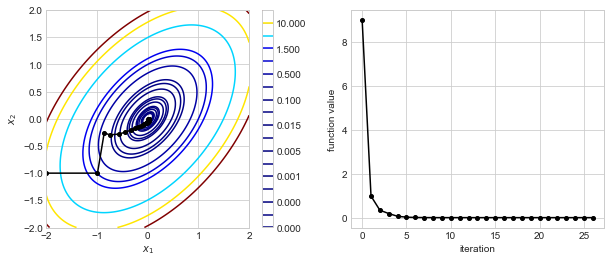

In [14]:
# BFGS without analytical jacobian 
x0 = [-2,-1] # suggested initial guess
evals = 0

result = optimize.minimize(f_python,x0,
                           method='BFGS',
                           callback=collect, # call the collect() before each iteration
                           options={'disp':True}) # display the results
contour()
info['BFGS without analytical jacobian'] = [result.nit,result.nfev,result.njev]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28


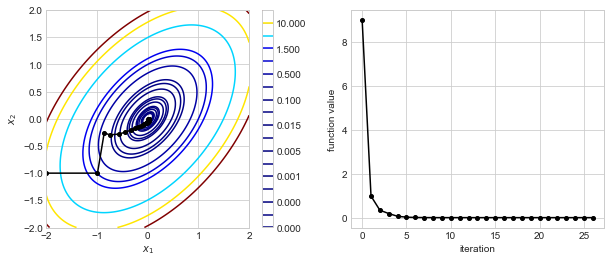

In [15]:
# BFGS with analytical jacobian 
x0 = [-2,-1] # suggested initial guess
evals = 0

result = optimize.minimize(f_python,x0,
                           method='BFGS',
                           jac= f_jac,
                           callback=collect, # call the collect() before each iteration
                           options={'disp':True}) # display the results
contour()
info['BFGS with analytical jacobian'] = [result.nit,result.nfev,result.njev]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 30
         Hessian evaluations: 15


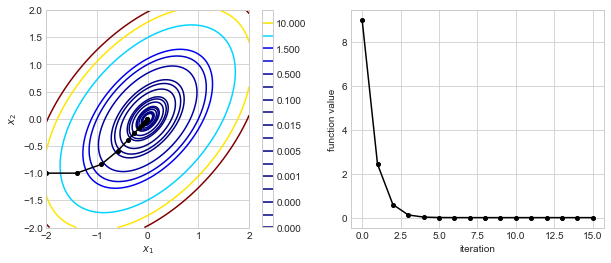

In [16]:
# Newton-CG with analytical jacobian and hessian
x0 = [-2,-1] # suggested initial guess
evals = 0

result = optimize.minimize(f_python,x0,
                           method='Newton-CG',
                           jac= f_jac,
                           hess = f_hess,
                           callback=collect, # call the collect() before each iteration
                           options={'disp':True}) # display the results

contour()
info['Newton-CG with analytical jacobian and hessian'] = [result.nit,result.nfev,result.njev, result.nhev]

**Comparison:**

In [17]:
print_list = [' iterations',' function evalutations:', ' jac evaluations', ' hess evaluations']
for key, value in info.items():
    print(key,':')
    for i, n in enumerate(value):
        print(' ',n, print_list[i])
    

Nelder-Mead :
  43  iterations
  83  function evalutations:
BFGS without analytical jacobian :
  26  iterations
  112  function evalutations:
  28  jac evaluations
BFGS with analytical jacobian :
  26  iterations
  28  function evalutations:
  28  jac evaluations
Newton-CG with analytical jacobian and hessian :
  15  iterations
  16  function evalutations:
  30  jac evaluations
  15  hess evaluations


Choosing the optimal optimizer is very much problem-dependent. Using analytical gradients typically saves computing power (seen by fewer iterations and evaluations), but of course calculating them analytically either requires some computation in sympy or by yourself. <br>
In the introduction of lecture 11, Jeppe has nice summary of pros and cons on the different scipy optimizers. 

**Answer:**

Nelder-Mead:
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 83


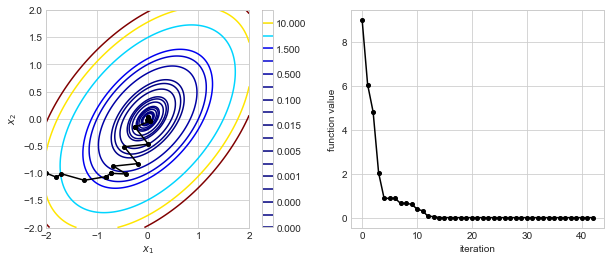

In [18]:
print('Nelder-Mead:')
evals = 0
result = optimize.minimize(f_python,x0,method='Nelder-Mead',callback=collect,options={'disp':True})
contour()

BFGS without analytical gradient:
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 112
         Gradient evaluations: 28


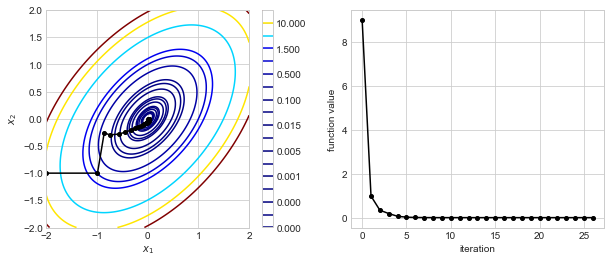

In [19]:
print('BFGS without analytical gradient:')

evals = 0
result = optimize.minimize(f_python,x0,method='BFGS',callback=collect,options={'disp':True})
contour()

BFGS with analytical gradient:
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 28
         Gradient evaluations: 28


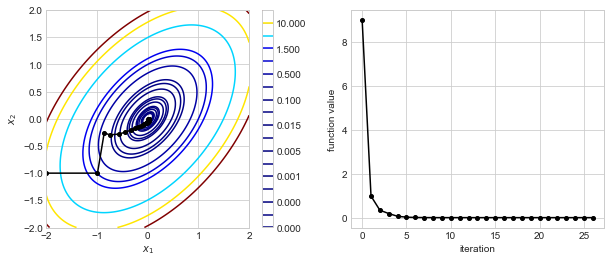

In [20]:
print('BFGS with analytical gradient:')

evals = 0
result = optimize.minimize(f_python,x0,jac=f_jac,method='BFGS',callback=collect,options={'disp':True})
contour()

Newton-CG with analytical gradient and hessian:
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 30
         Hessian evaluations: 15


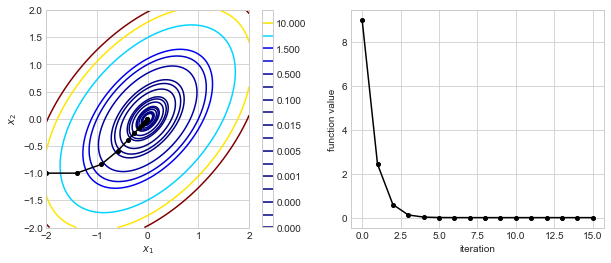

In [21]:
print('Newton-CG with analytical gradient and hessian:')

evals = 0
result = optimize.minimize(f_python,x0,jac=f_jac,hess=f_hess,method='Newton-CG',callback=collect,options={'disp':True})
contour()

## Optimization problem II

Consider the function

$$
f(x_1,x_2) = (4-2.1x_1^2 + \frac{x_1^4}{3})x_1^2 + x_1x_2 + (4x_2^2 - 4)x_2^2)
$$

Define it in **sympy** by:

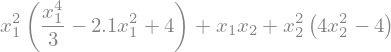

In [22]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = (4-2.1*x1**2 + (x1**4)/3)*x1**2 + x1*x2 + (4*x2**2 - 4)*x2**2
_f = sm.lambdify((x1,x2),f)
f

Create **3D plot**:

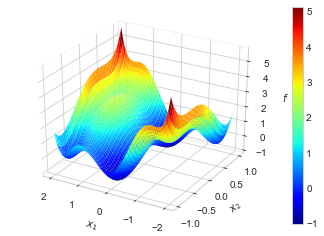

In [23]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-1,1,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
f_grid = _f(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,f_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# e. remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# f. add colorbar
fig.colorbar(cs);

In [24]:
# a. python function for f
f_python = lambda x: _f(x[0],x[1])

# b. initial guesses
np.random.seed(1986)
K = 1000
x0s = np.empty((K,2))
x0s[:,0] = -2 + 4*np.random.uniform(size=K)
x0s[:,1] = -1 + 2*np.random.uniform(size=K)

# c. solutions and associated values
xs = np.empty((K,2))
fs = np.empty(K)

# Store sympys in lists: 
s_xs = [x1,x2]
jacs = [sm.diff(f,x) for x in s_xs]
hessians = [sm.diff(f,xa,xb) for xa in s_xs for xb in s_xs]

# generate python versions:
_jacs = [sm.lambdify(s_xs,jac) for jac in jacs]
_hessians = [sm.lambdify(s_xs,hess) for hess in hessians]

def f_jac(x):
    return np.array([jac(*x) for jac in _jacs])

def f_hess(x):
    answer = [hess(*x) for hess in _hessians]
    return np.array([answer[:2],answer[2:]])



**Question A:** Find the minimum of the function starting from each of the suggested initial values below. Print the first 20 solutions, and all solutions aftwards, which is the best yet to be found. Save the solutions and associated function values in `xs` and `fs`.

In [25]:
f_best= np.inf
for i in range(K):
    result = optimize.minimize(f_python,x0s[i],
                           method='Newton-CG',
                           jac= f_jac,
                           hess = f_hess) # display the results
    xs[i], fs[i] = result.x, result.fun
    
    best = False
    if fs[i]<f_best:
        f_best= fs[i]
        x_best = xs[i]
        best = True 
        
    if i<21 or best:
        print(f'{i:4}: x0 = ({x0s[i][0]:6.2f},{x0s[i][1]:6.2f}) -> converged at ({xs[i][0]:6.2f},{xs[i][1]:6.2f}) with f = {fs[i]:15.10f}')
    

   0: x0 = (  0.28, -0.58) -> converged at (  0.09, -0.71) with f =   -1.0316284535
   1: x0 = ( -1.69, -0.97) -> converged at ( -1.61, -0.57) with f =    2.1042503103
   2: x0 = (  0.43, -0.80) -> converged at (  0.09, -0.71) with f =   -1.0316284535
   3: x0 = (  1.59,  0.70) -> converged at (  1.61,  0.57) with f =    2.1042503103
   4: x0 = (  0.18, -0.25) -> converged at (  0.09, -0.71) with f =   -1.0316284535
   5: x0 = (  0.81,  0.51) -> converged at ( -0.09,  0.71) with f =   -1.0316284535
   6: x0 = ( -0.46,  0.41) -> converged at ( -0.09,  0.71) with f =   -1.0316284535
   7: x0 = (  0.61, -0.89) -> converged at (  0.09, -0.71) with f =   -1.0316284535
   8: x0 = (  0.76,  0.66) -> converged at ( -0.09,  0.71) with f =   -1.0316284535
   9: x0 = (  0.87,  0.53) -> converged at ( -0.09,  0.71) with f =   -1.0316284535
  10: x0 = (  0.76,  0.14) -> converged at ( -0.09,  0.71) with f =   -1.0316284535
  11: x0 = (  1.23,  0.11) -> converged at (  1.70, -0.80) with f =   -0.215

In [26]:
print('Best solution:',x_best,f_best)

Best solution: [ 0.08984201 -0.7126564 ] -1.0316284534898774


**Answer:**

In [27]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s):
    
    # a. optimize
    result = optimize.minimize(f_python,x0,method='BFGS')
    xs[i,:] = result.x
    fs[i] = result.fun
    
    # b. print first 20 or if better than seen yet
    if i < 20 or fs[i] < fopt: # plot 20 first or if improving
        if fs[i] < fopt:
            xopt = xs[i,:]
            fopt = fs[i]
        print(f'{i:4d}: x0 = ({x0[0]:6.2f},{x0[0]:6.2f})',end='')
        print(f' -> converged at ({xs[i][0]:6.2f},{xs[i][1]:6.2f}) with f = {fs[i]:.12f}')
        
# best solution
print(f'\nbest solution:\n x = ({xopt[0]:6.2f},{xopt[1]:6.2f}) -> f = {fopt:.12f}')

   0: x0 = (  0.28,  0.28) -> converged at (  0.09, -0.71) with f = -1.031628453485
   1: x0 = ( -1.69, -1.69) -> converged at ( -1.70,  0.80) with f = -0.215463824384
   2: x0 = (  0.43,  0.43) -> converged at (  0.09, -0.71) with f = -1.031628453490
   3: x0 = (  1.59,  1.59) -> converged at (  1.70, -0.80) with f = -0.215463824384
   4: x0 = (  0.18,  0.18) -> converged at (  0.09, -0.71) with f = -1.031628453490
   5: x0 = (  0.81,  0.81) -> converged at ( -0.09,  0.71) with f = -1.031628453490
   6: x0 = ( -0.46, -0.46) -> converged at ( -0.09,  0.71) with f = -1.031628453487
   7: x0 = (  0.61,  0.61) -> converged at (  0.09, -0.71) with f = -1.031628453490
   8: x0 = (  0.76,  0.76) -> converged at ( -0.09,  0.71) with f = -1.031628453484
   9: x0 = (  0.87,  0.87) -> converged at ( -0.09,  0.71) with f = -1.031628453490
  10: x0 = (  0.76,  0.76) -> converged at ( -0.09,  0.71) with f = -1.031628453489
  11: x0 = (  1.23,  1.23) -> converged at (  1.70, -0.80) with f = -0.21546

**Question B:** Create a 3D scatter plot of where the optimizer converges, and color the dots by the associated function values.

In [28]:
import matplotlib

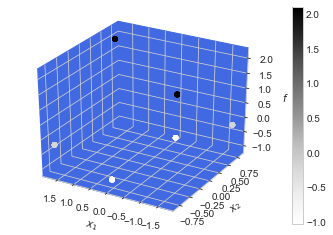

In [29]:
f_max = np.max(fs)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')

cs = ax.scatter(xs[:,0],xs[:,1],fs,c=fs)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()


# make background blue to make dots more visibleax.xaxis.pane.fill = False
rgba_blue = matplotlib.colors.to_rgba('royalblue') # .set_pane_color uses rgba-codes normalized to (0,1) this function otuput the correct code 
ax.w_xaxis.set_pane_color(rgba_blue)
ax.w_yaxis.set_pane_color(rgba_blue)
ax.w_zaxis.set_pane_color(rgba_blue)


# f. add colorbar
fig.colorbar(cs);

**Answer:**

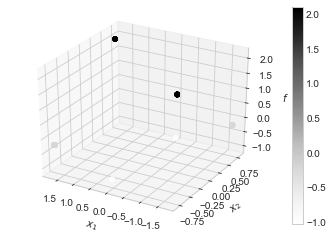

In [30]:
# a. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(xs[:,0],xs[:,1],fs,c=fs);        

# b. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# c. invert xaxis
ax.invert_xaxis()


# d. colorbar
fig.colorbar(cs);

**Question C:** Plot the function values at the solutions as a function of the starting values.

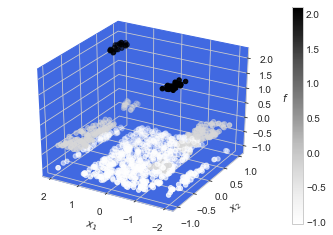

In [31]:
# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(x0s[:,0],x0s[:,1],fs,c=fs)


# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# d. invert xaxis
ax.invert_xaxis()

# make background blue to make dots more visibleax.xaxis.pane.fill = False

rgba_blue = matplotlib.colors.to_rgba('royalblue') # .set_pane_color uses rgba-codes normalized to (0,1) this function otuput the correct code 
ax.w_xaxis.set_pane_color(rgba_blue)
ax.w_yaxis.set_pane_color(rgba_blue)
ax.w_zaxis.set_pane_color(rgba_blue)


# f. add colorbar
fig.colorbar(cs);

**Answer:**

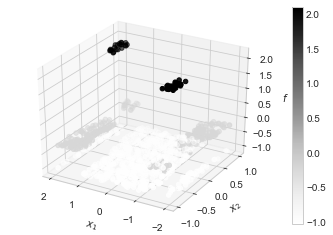

In [32]:
# a. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(x0s[:,0],x0s[:,1],fs,c=fs);        

# b. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f$')

# c. invert xaxis
ax.invert_xaxis()

# d. colorbar
fig.colorbar(cs);

In [33]:
sm.init_printing(pretty_printing=False)

# Problem: Solve the consumer problem with income risk I

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is consumption in period $t$
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
 \text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) & = 
\max_{c_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right] \\
\text{s.t.} \\
m_2 &= (1+r)(m_{1}-c_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

The **basic functions** are:

In [34]:
def utility(c,rho):
    return c**(1-rho)/(1-rho)

def bequest(m,c,nu,kappa,rho):
    return nu*(m-c+kappa)**(1-rho)/(1-rho)

def v2(c2,m2,rho,nu,kappa):
    return utility(c2,rho) + bequest(m2,c2,nu,kappa,rho)

def v1(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1) + 1-Delta
    v2_low = v2_interp([m2_low])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1) + 1+Delta
    v2_high = v2_interp([m2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,rho) + beta*v2

The **solution functions** are:

In [35]:
def solve_period_2(rho,nu,kappa,Delta):

    # a. grids
    m2_vec = np.linspace(1e-4,5,500)
    v2_vec = np.empty(500)
    c2_vec = np.empty(500)

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):

        # i. objective
        obj = lambda c2: -v2(c2,m2,rho,nu,kappa)

        # ii. initial value (consume half)
        x0 = m2/2

        # iii. optimizer
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

        # iv. save
        v2_vec[i] = -result.fun
        c2_vec[i] = result.x
        
    return m2_vec,v2_vec,c2_vec

def solve_period_1(rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-4,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda c1: -v1(c1,m1,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess (consume half)
        x0 = m1*1/2
        
        # iii. optimize
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m1])
        
        # iv. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x
     
    return m1_vec,v1_vec,c1_vec

**Question A:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it.

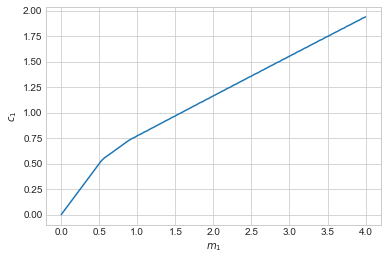

In [36]:
rho = 8
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

# b. solve
def solve_1(rho,nu,kappa,Delta,beta,r,v1):
    m2_vec,v2_vec,c2_vec = solve_period_2(rho,nu,kappa,Delta)

    v2_interp = interpolate.RegularGridInterpolator([m2_vec],v2_vec,bounds_error=False,fill_value=None)

    m1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,Delta,v1,v2_interp)
    return m1_vec, c1_vec

m1_vec, c1_vec =solve_1(rho,nu,kappa,Delta,beta,r,v1)


# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec)

ax.set_xlabel('$m_{1}$')
ax.set_ylabel('$c_{1}$')

ax.grid(True)


**Answer:**

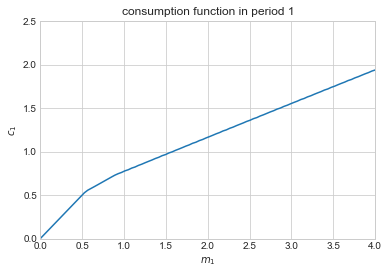

In [37]:
# b. solve
def solve(rho,beta,r,Delta,nu,kappa,v1):
    
    # a. solve period 2
    m2_vec,v2_vec,c2_vec = solve_period_2(rho,nu,kappa,Delta)
    
    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator((m2_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)
    
    # b. solve period 1
    m1_vec,v1_vec,c1_vec = solve_period_1(rho,beta,r,Delta,v1,v2_interp)
    
    return m1_vec,c1_vec

m1_vec,c1_vec = solve(rho,beta,r,Delta,nu,kappa,v1)

# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

**Question B:** Find optimal consumption in the first period as funcition of cash-on-hand, and plot it, assuming that

$$ 
y_{2} = \begin{cases}
1-\sqrt{\Delta} & \text{with prob. }0.1\\
1-\Delta & \text{with prob. }0.4\\
1+\Delta & \text{with prob. }0.4\\ 
1+\sqrt{\Delta} & \text{with prob. }0.1
\end{cases}
$$

which add some low probability tail events, but does not change mean income. Give an interpretation of the change in the consumption function.

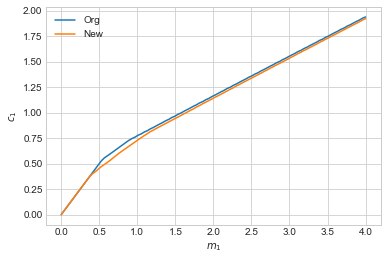

In [38]:
def v1_new(c1,m1,rho,beta,r,Delta,v2_interp):
    
    probabilities= [0.1,0.4,0.4,0.1]
    deltas = [-np.sqrt(Delta),-Delta,Delta,np.sqrt(Delta)]
    m2s = [(1+r)*(m1-c1)+1+d for d in deltas]
    v2s = [v2_interp([m2])[0] for m2 in m2s]
        
    
    # c. expected v2 value
    v2 = np.sum([v2*p for v2,p in zip(v2s,probabilities)])
    
    # d. total value
    return utility(c1,rho) + beta*v2

m1_vec_new, c1_vec_new =solve_1(rho,nu,kappa,Delta,beta,r,v1_new)


# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec,label='Org')
ax.plot(m1_vec_new, c1_vec_new,label='New')
ax.set_xlabel('$m_{1}$')
ax.set_ylabel('$c_{1}$')
ax.legend(loc = 'upper left')
ax.grid(True)

**Answer:**

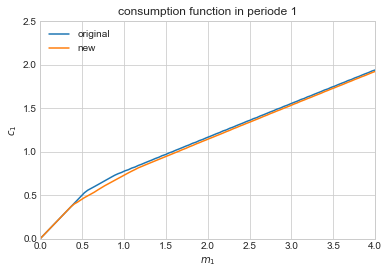

In [39]:
def v1_alt(c1,m1,rho,beta,r,Delta,v2_interp):
    
    # a. expected v2 value
    Ra = (1+r)*(m1-c1)
    v2 = 0
    y2s = [1-np.sqrt(Delta),1-Delta,1+Delta,1+np.sqrt(Delta)]
    probs = [0.1,0.4,0.4,0.1]
    for y2,prob in zip(y2s,probs):
        m2 = Ra + y2
        v2 += prob*v2_interp([m2])[0]
        
    # b. total value
    return utility(c1,rho) + beta*v2

m1_vec_alt,c1_vec_alt = solve(rho,beta,r,Delta,nu,kappa,v1_alt)

# plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec,label='original')
ax.plot(m1_vec_alt,c1_vec_alt,label='new')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in periode 1')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);

# Problem: Solve the consumer problem with income risk II

Define the following **variables** and **parameters**:

* $m_t$ is cash-on-hand in period $t$
* $c_t$ is non-durable consumption in period $t$
* $d_t$ is durable consumption in period $t$ (only adjustable in period 1)
* $y_t$ is income in period $t$
* $\Delta \in (0,1)$ is income risk
* $r$ is the interest rate
* $\beta > 0$, $\rho > 1$, $\alpha \in (0,1)$, $\nu > 0 $, $\kappa > 0$, $\xi > 0$ are utility parameters

In the **second period** the household solves:

$$
\begin{aligned}
v_{2}(m_{2},d_{2}) &= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\alpha\frac{d_{2}^{1-\rho}}{1-\rho}+\nu\frac{(m_{2}+d_{2}-c_{2}+\kappa)^{1-\rho}}{1-\rho} \\
\text{s.t.} \\
c_{2} & \in [0,m_{2}]
\end{aligned}
$$

In the **first period** the household solves:

$$
\begin{aligned}
v_{1}(m_{1}) &= \max_{c_{1},d_{1}}\frac{c_{1}^{1-\rho}}{1-\rho}+\alpha\frac{d_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2,d_2)\right]\\&\text{s.t.}&\\
m_2 &= (1+r)(m_{1}-c_{1}-d_{1})+y_{2} \\
y_{2} &= \begin{cases}
1-\Delta & \text{with prob. }0.5\\
1+\Delta & \text{with prob. }0.5 
\end{cases}\\
c_{1}+d_{1} & \in [0,m_{1}]\\
\end{aligned}
$$

Choose **parameters**:

In [40]:
rho = 2
alpha = 0.1
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.94
Delta = 0.5

# b. solve
# write your code here

# c. plot
# write your code here

The **basic functions** are:

In [41]:
def utility(c,d,alpha,rho):
    return c**(1-rho)/(1-rho) + alpha*d**(1-rho)/(1-rho)

def bequest(m,c,d,nu,kappa,rho):
    return nu*(m+d-c+kappa)**(1-rho)/(1-rho)

def v2(c2,d2,m2,alpha,rho,nu,kappa):
    return utility(c2,d2,alpha,rho) + bequest(m2,c2,d2,nu,kappa,rho)

def v1(c1,d1,m1,alpha,rho,beta,r,Delta,v2_interp):
    
    # a. v2 value, if low income
    m2_low = (1+r)*(m1-c1-d1) + 1-Delta
    v2_low = v2_interp([m2_low,d1])[0]
    
    # b. v2 value, if high income
    m2_high = (1+r)*(m1-c1-d1) + 1+Delta
    v2_high = v2_interp([m2_high,d1])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total value
    return utility(c1,d1,alpha,rho) + beta*v2

The **solution function for period 2** is:

In [42]:
def solve_period_2(alpha,rho,nu,kappa,Delta,size=100):
    
    # a. grids
    m2_vec = np.linspace(1e-4,5,size)
    d2_vec = np.linspace(1e-4,5,size)
    v2_grid = np.empty((size,size))
    c2_grid = np.empty((size,size))

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d2 in enumerate(d2_vec):

            # i. objective
            obj = lambda c2: -v2(c2,d2,m2,alpha,rho,nu,kappa)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

            # iv. save
            v2_grid[i,j] = -result.fun
            c2_grid[i,j] = result.x
        
    return m2_vec,d2_vec,v2_grid,c2_grid

**Question A:** Solve for consumption in period 2 and plot the consumption function.

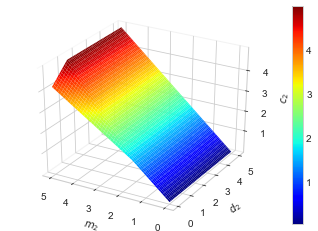

In [43]:
m2_vec,d2_vec,v2_grid,c2_grid = solve_period_2(alpha,rho,nu,kappa,Delta)

m2_grid,d2_grid = np.meshgrid(m2_vec,d2_vec,indexing='ij')

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d2_grid,c2_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$m_{2}$')
ax.set_ylabel('$d_{2}$')
ax.set_zlabel('$c_{2}$')

# d. invert xaxis
ax.invert_xaxis()

# e. remove background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# f. add colorbar
fig.colorbar(cs);

**Answer:**

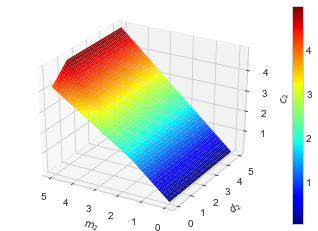

In [44]:
# a. solve
m2_vec,d2_vec,v2_grid,c2_grid = solve_period_2(alpha,rho,nu,kappa,Delta)

# b. grids
m2_grid,d2_grid = np.meshgrid(m2_vec,d2_vec,indexing='ij')

# c. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d2_grid,c2_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d_2$')
ax.set_zlabel('$c_2$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

**Question B:** Find optimal consumption and choices of durables in the first period as a function of cash-on-hand and plot it.

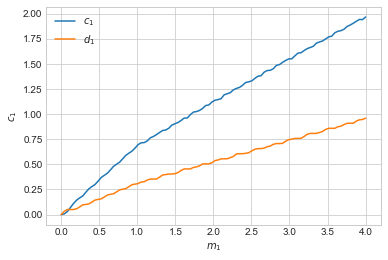

In [45]:
v2_interp = interpolate.RegularGridInterpolator([m2_vec,d2_vec], v2_grid,
                                                    bounds_error=False,fill_value=None)


def solve_1(alpha,rho,nu,kappa,Delta,beta,r,v2_interp,size=100):
    m1s = np.linspace(1e-4,4,size)
    c1s,d1s,v1s = [np.empty(size) for i in range(3)]
    
    for i, m1 in enumerate(m1s):
        
        obj = lambda x: -v1(x[0],x[1],m1,alpha,rho,beta,r,Delta,v2_interp)
        
        constraints = ({'type': 'ineq', 'fun': lambda x:  m1-x[0]-x[1]})
        bounds = [[1e-6,m1-1e-6],[1e-6,m1-1e-6]]
        
        guess = [m1/2,m1/2]
        result = optimize.minimize(obj,guess,method='SLSQP',
                                   constraints=constraints, bounds=bounds)
        v1s[i] = -result.fun
        c1s[i],d1s[i]=result.x
    return v1s,d1s, c1s,m1s

v1s,d1s, c1s,m1s = solve_1(alpha,rho,nu,kappa,Delta,beta,r,v2_interp)

# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1s,c1s,label='$c_{1}$')
ax.plot(m1s,d1s ,label='$d_{1}$')
ax.set_xlabel('$m_{1}$')
ax.set_ylabel('$c_{1}$')
ax.legend(loc = 'upper left')
ax.grid(True)


**Answer:**

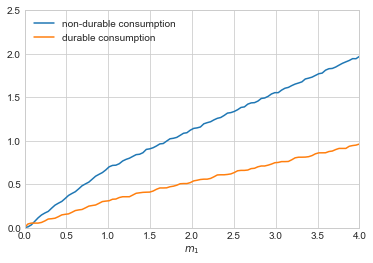

In [ ]:
# a. define solve function
def solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-4,4,100)
    v1_vec = np.empty(100)
    c1_vec = np.empty(100)
    d1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda x: -v1(x[0],x[1],m1,alpha,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess
        x0 = [m1*1/3,m1*1/3]
        
        # iii. bounds and constraitns
        bound = (1e-8,m1-1e-8)
        bounds = (bound, bound)
        ineq_con = {'type': 'ineq', 'fun': lambda x: m1-x[0]-x[1]} 
        
        # iv. optimize
        result = optimize.minimize(obj,x0, method='SLSQP',
                                   bounds=bounds,
                                   constraints=[ineq_con])
        
        #result = optimize.minimize(obj,x0, method='Nelder-Mead')
        
        # v. save
        v1_vec[i] = -result.fun
        c1_vec[i] = result.x[0]
        d1_vec[i] = result.x[1]
     
    return m1_vec,v1_vec,c1_vec,d1_vec

# b. construct interpolator
v2_interp = interpolate.RegularGridInterpolator((m2_vec,d2_vec), v2_grid,
                                                bounds_error=False,fill_value=None)
    
# c. solve period 1
m1_vec,v1_vec,c1_vec,d1_vec = solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp)

# d. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,c1_vec,label='non-durable consumption')
ax.plot(m1_vec_alt,d1_vec,label='durable consumption')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_xlim([0,4])
ax.set_ylim([0,2.5]);